# Projekt zespołowy
## Temat: Rozpoznawanie cyfr pisanych odręcznie (ze zbioru MNIST)
### Wykonali: Prz-mek (github), Dominik Wawrzyniuk

### Źródło danych
Baza danych MNIST jest bazą czarno-białych obrazów odręcznie pisanych cyfr arabskich w rozdzielczości 28×28 pikseli. Baza zawiera 60 000 obrazów szkoleniowych i 10 000 obrazów testowych. Ponieważ zbiór posiada już podział na dane uczące i testowe postanowiliśmy nie stosować innych podziałów.

### Cel pracy
Zadaniem naszego zespołu będzie zbadanie skuteczności rozpoznawania cyfr z bazy
MNIST za pomocą różnych rodzajów klasyfikatorów uczenia nadzorowanego.
Wykorzystane przez nas sposoby klasyfikacji to:
* naiwny klasyfikator Bayesa
* metoda najbliższego centroidu
* regresja logistyczna
* klasyfikator k najbliższych sąsiadów
* maszyna wektorów nośnych
* "podstawowa" sieć neuronowa
* konwolucyjna sieć neuronowa

Wczytanie niezbędnych pakietów:

In [2]:
import time
import random
from warnings import filterwarnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import skimage as si
import skimage.measure as sime

# uczenie nadzorowane scikitlearn
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning

# TensorFlow
import tensorflow as tf

Funkcje pomocnicze:

In [2]:
def show_MNIST_images(imlist, tilist):
    size = 3
    cols = 6
    rows = int(len(imlist) / cols)
    if len(imlist) % cols > 0:
        rows += 1
    plt.figure(figsize=(cols*size,rows*size))
    for i in range(0,len(imlist)):
        plt.subplot(rows,cols,i+1)
        plt.axis('off')
        plt.imshow(imlist[i],cmap='gray')
        plt.title(tilist[i])

def prepare_data(desc_learn, desc_test, class_learn, class_test, proportion=1.0):
    if proportion < 1.0:
        learn_num = int(proportion*desc_learn.shape[0])
        test_num = int(proportion*desc_test.shape[0])
        learn_sample = random.sample(range(0,desc_learn.shape[0]), learn_num)
        test_sample = random.sample(range(0,desc_test.shape[0]), test_num)
        desc_learn = desc_learn[learn_sample]
        desc_test = desc_test[test_sample]
        class_learn = class_learn[learn_sample]
        class_test = class_test[test_sample]
    return {'desc_learn': desc_learn, 'desc_test': desc_test, 'class_learn': class_learn, 'class_test': class_test}

def train(data, model):
    model.fit(data['desc_learn'], data['class_learn'])

def verify(data,model,in_percents=False):
    pred = model.predict(data['desc_test'])
    if pred.ndim > 1:
        pred = np.argmax(pred,axis=-1)
    if data['class_test'].ndim > 1:
        data['class_test'] = np.argmax(data['class_test'],axis=-1)
    mat_err_test = pd.crosstab(data['class_test'],pred)
    if in_percents:
        mat_err_test = mat_err_test.astype('float64')
        for row in range(0,mat_err_test.shape[0]):
            sample_size = mat_err_test.iloc[row,:].sum()
            for col in range(0,mat_err_test.shape[1]):
                mat_err_test.at[row,col] = round(100*mat_err_test.at[row,col]/sample_size,1)
    plt.imshow(mat_err_test)
    plt.title('Macierz pomyłek dla zbioru testowego')
    plt.colorbar()
    for row in range(0,mat_err_test.shape[0]):
        for col in range(0,mat_err_test.shape[1]):
            plt.text(col,row,mat_err_test.at[row,col],horizontalalignment='center')
    plt.tight_layout()
    plt.ylabel('Prawidłowe')
    plt.xlabel('Przewidziane')
    
def mesure_predict_time(data,model):
    start = time.time()
    model.predict(data['desc_test'])
    stop = time.time()
    mesurement = stop-start
    return mesurement, mesurement/len(data['desc_test'])

def print_avg_time(data,model):
    time_per_image = mesure_predict_time(data,model)[1]
    print('Średni czas poświęcony na klasyfikację jednego obrazu {:.3f} ms.'.format(time_per_image*10**3))
    
def reacale_images(array, margin=0, scale=0.5):
    edited = []
    for img in array:
        if margin != 0:
            width = img.shape[0]
            height = img.shape[1]
            img = img[margin:height-margin,margin:width-margin]
        edited.append(si.transform.rescale(img, scale, anti_aliasing=False))
    return np.array(edited)

Wczytanie danych (MNIST):

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

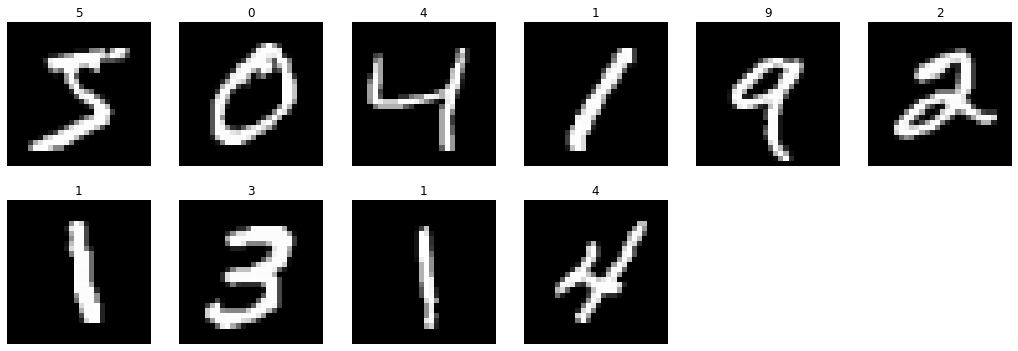

In [4]:
show_MNIST_images(x_train[0:10], y_train[0:10])

## 1. Analiza danych

Na początku warto sprawdzić czy obrazy cyfr zawierają jakieś cechy charakterystyczne, które pozwolą nam identyfikować cyfrę na podstawie samych tych cech. Poniżej funkcja wczytująca cechy do macierzy. Poniższa funkcja zapisuje tylko wartości cech pierwszego obiektu. Robi tak dlatego, że czasami obrazki cyfr są błędnie traktowane jako więcej niż jeden obiekt. Zapisując tylko pierwszy obiekt błędy te są prostsze do wychwycenia.

In [4]:
def read_features(start, end, feats):
    cechy = []
    for i in range(start, end):
        binary = x_train[i] > 100
        label = sime.label(binary)
        features = sime.regionprops(label)
        obiekt = []
        for feat in feats:
            obiekt.append(features[0][feat])
        obiekt.append(features[0].centroid[0])
        obiekt.append(features[0].centroid[1])
        cechy.append(obiekt)
    return cechy

Wczytywanie cech 10 000 obrazów cyfr:

In [5]:
last = 10000
lista_cech = ['EulerNumber','Area','BoundingBoxArea','FilledArea','Extent','EquivDiameter','Solidity', 'Orientation', 'Perimeter', 'Eccentricity']
cechy = read_features(0, last, lista_cech)
lista_cech.append('x')
lista_cech.append('y')
cechy = pd.DataFrame(cechy, columns = lista_cech)
cechy.insert(cechy.shape[1], 'Wypełnienie bez dziur', cechy['FilledArea'] / cechy['BoundingBoxArea'])
cechy.insert(cechy.shape[1], 'Cyfra', y_train[:last])
cechy

,EulerNumber,Area,BoundingBoxArea,FilledArea,Extent,EquivDiameter,Solidity,Orientation,Perimeter,Eccentricity,x,y,Wypełnienie bez dziur,Cyfra
0,1,117,400,117,0.292500,12.205287,0.428571,-0.336665,84.941125,0.859000,14.102564,13.606838,0.292500,5
1,0,130,320,221,0.406250,12.865502,0.567686,-0.555812,79.319805,0.777376,13.676923,14.338462,0.690625,0
2,1,89,380,89,0.234211,10.645108,0.326007,1.368025,70.106602,0.742498,14.067416,13.179775,0.234211,4
3,1,70,240,70,0.291667,9.440697,0.769231,-0.513867,49.455844,0.988753,14.557143,13.942857,0.291667,1
4,0,97,280,119,0.346429,11.113246,0.532967,-0.030880,61.248737,0.751730,13.979381,13.742268,0.425000,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,121,400,121,0.302500,12.412171,0.491870,-0.440976,79.148232,0.902530,14.115702,13.727273,0.302500,5
9996,0,113,400,140,0.282500,11.994835,0.397887,0.059903,103.177670,0.648020,13.610619,14.442478,0.350000,8
9997,1,114,240,114,0.475000,12.047793,0.765101,-0.355391,59.112698,0.929840,14.061404,14.263158,0.475000,6
9998,0,82,220,109,0.372727,10.217908,0.585714,0.122516,65.177670,0.833590,13.390244,14.329268,0.495455,9


Wyświetlamy wykresy skrzypcowe w celu zobaczenia rozkładu wartości atrybutów dla każdej z cyfr.

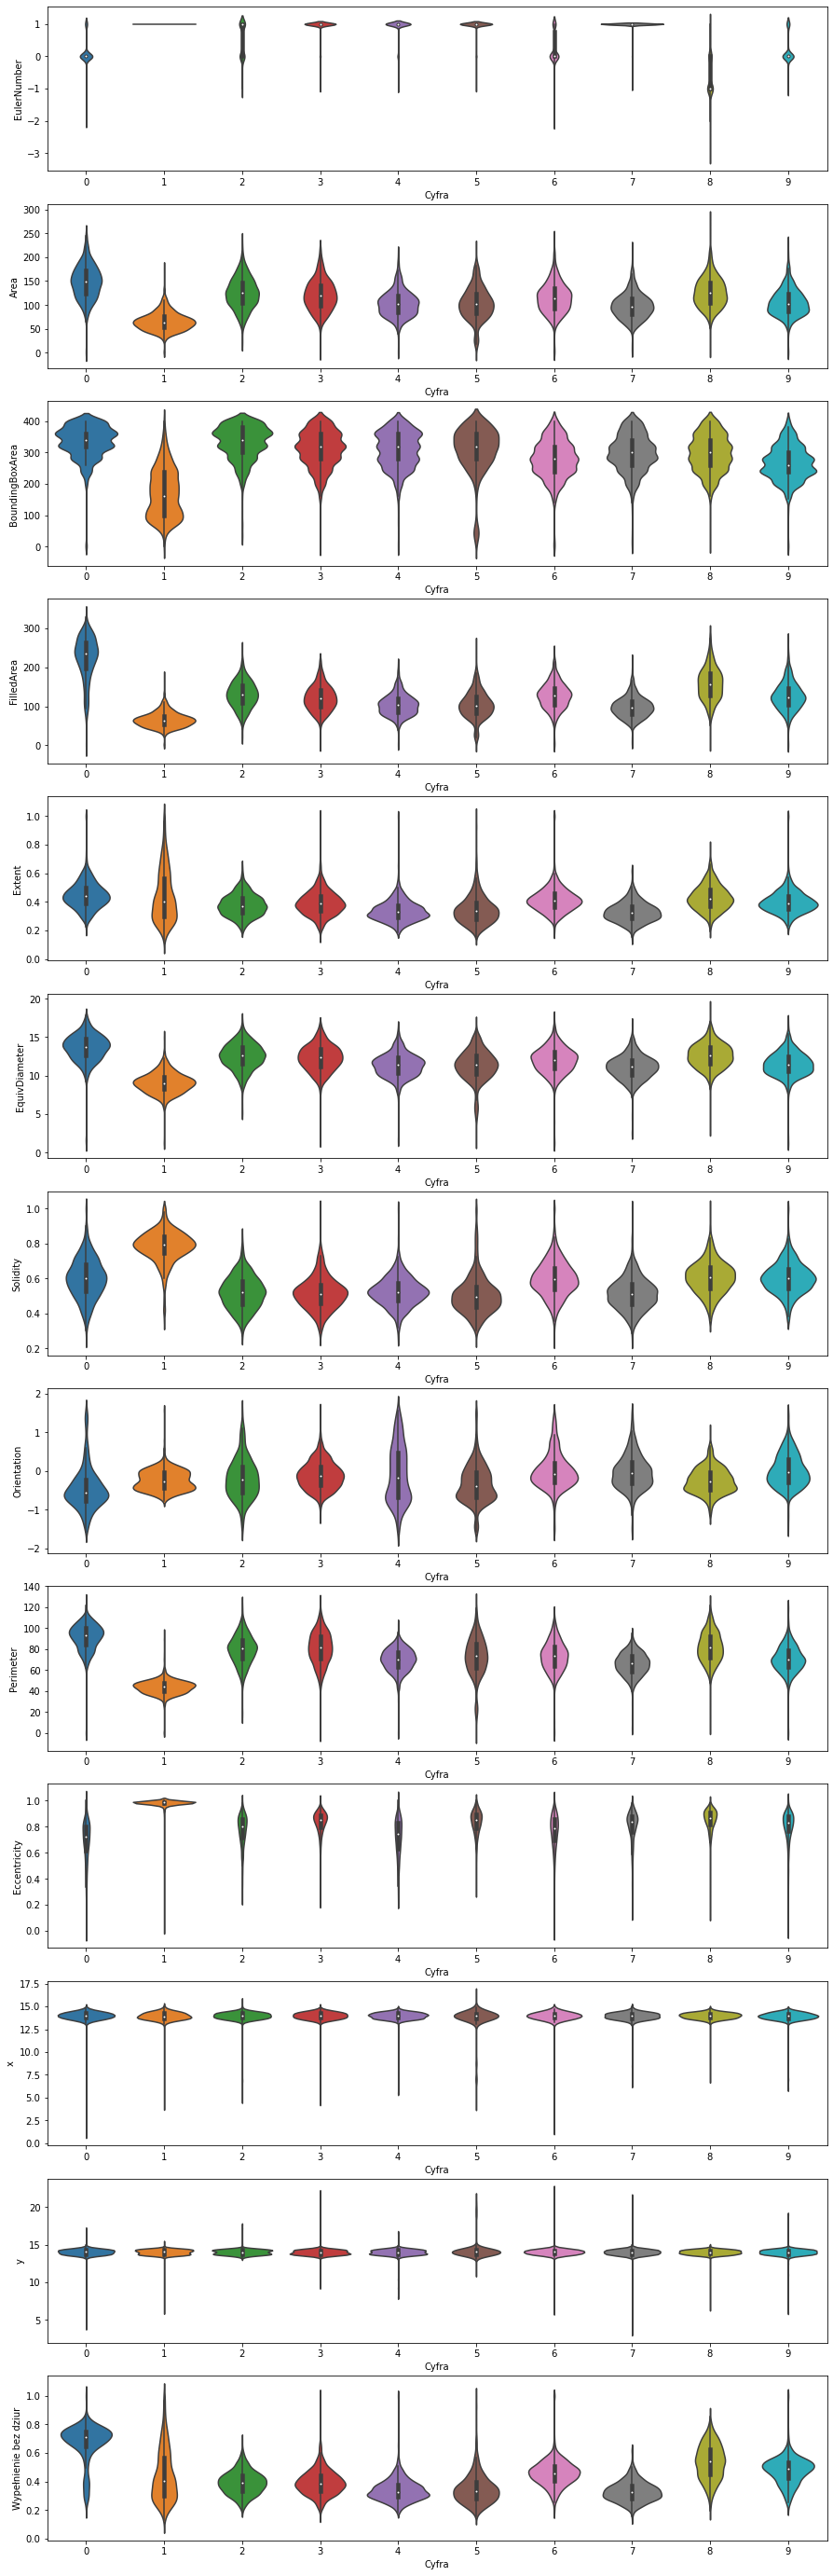

In [6]:
filterwarnings('ignore', category=FutureWarning)
for i in range(0, 10):
    cechy_cyfry = cechy[cechy['Cyfra'] == i]
plt.figure(figsize=(15, 50))
for i, cecha in enumerate(cechy):
    if (cecha == 'Cyfra'):
        break
    plt.subplot(cechy.shape[1] - 1, 1, i+1)
    sns.violinplot(x = cechy['Cyfra'], y = cechy[cecha])

* Po wstępnych obserwacjach możemy zauważyć, że współrzędne centroidów są bezużyteczne w celu rozdzielania cyfr. Dla każdej cyfry rozkład ich jest taki sam.
* Ciekawą obserwacją jest fakt, że większość cyfr przyjmuje merytorycznie błędne wartości dla niektórych atrybutów. Przykładowo minimalna wartość powierzchni prawie każdej cyfry jest ujemna, co jest oczywiści niemożliwe. Wynika to z tego, że podczas etykietowania danych niektóre obrazy cyfr skutkują podziałem na więcej niż jeden obiekt, więc cechy tych obiektów mogą być skrajnie nieprzewidywalne. Z wykresów skrzypcowych możemy zauważyć, że najgęstszy histogram przy niepoprawnych wartościach ma cyfra 5, więc ona prawdopodobnie najczęściej jest błędnie traktowana jako więcej niż jeden obiekt.

Wyznaczenie korelacji liniowej atrybutów:

<AxesSubplot:>

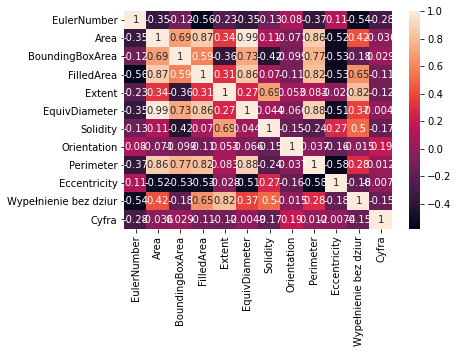

In [7]:
dobre_cechy = cechy.drop(columns = ['x', 'y'])
kor = dobre_cechy.corr()
sns.heatmap(kor, annot=kor)

Możemy zauważyć, że np. atrybuty EquivDiameter oraz Area mają korelację liniową o wartości 0.99, więc można spokojnie jeden z tych atrybutów usunąć. Zamiast jednak usuwać każdy atrybut, który uznamy za nadmiarowy ręcznie, posłużymy się funkcją, która usuwa atrybuty z korelacją powyżej wyznaczonego poziomu.

Funkcja usuwająca atrybuty nadmiarowe:

In [8]:
def removeFeatures(frame, bound):
    kor = frame.corr()
    for i in range(len(kor)):
        col = kor.columns[i]
        for j in range(i + 1, len(kor)):
            row = kor.columns[j]
            if (kor[row][col] > bound or kor[row][col] < -bound):
                return(removeFeatures(frame.drop(columns = [col]), bound))
    return frame

Atrybuty o wartości bezwzględnej korelacji większej od 0.8 uznamy za skorelowane liniowo i jeden z nich będzie usunięty jako atrybut nadmiarowy.

Atrybuty po usunięciu atrybutów nadmiarowych:

<AxesSubplot:>

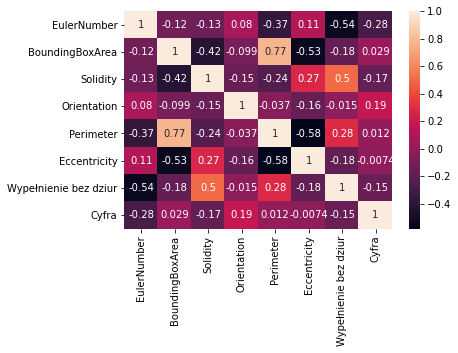

In [9]:
dobre_cechy = removeFeatures(dobre_cechy, 0.8)
kor = dobre_cechy.corr()
sns.heatmap(kor, annot = kor)

Teraz kiedy mamy tylko niezależne atrybuty, wyświetlimy ich histogramy i wykresy punktowe par.

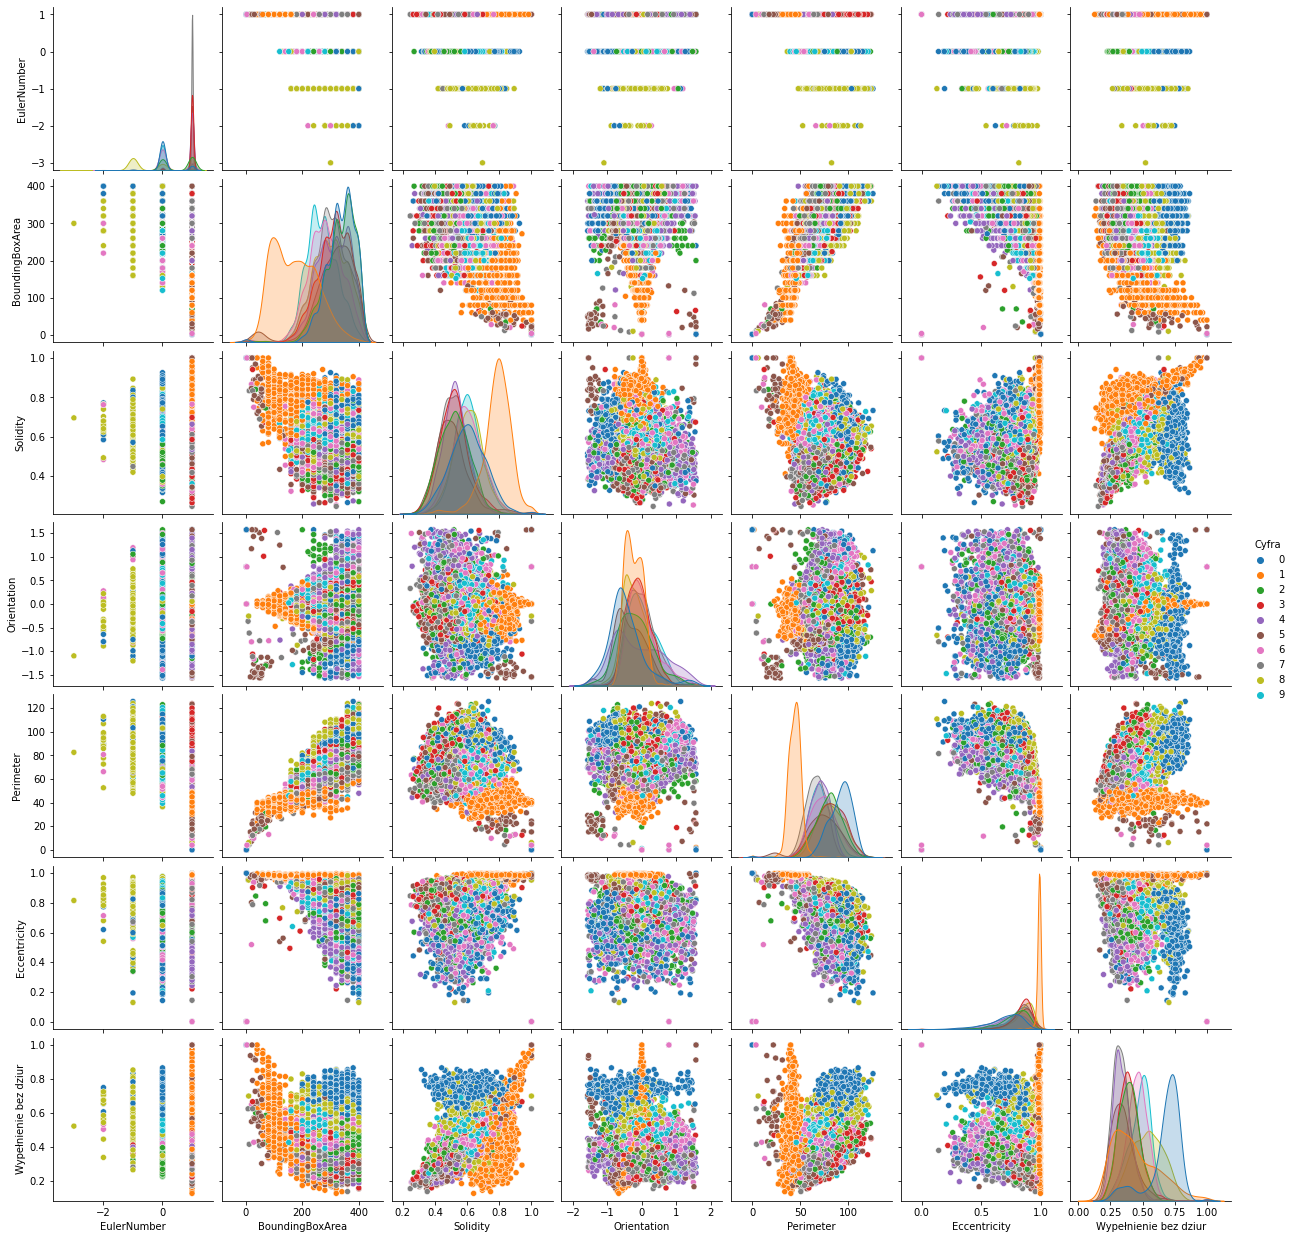

In [10]:
filterwarnings('ignore', category=UserWarning)
sns.pairplot(dobre_cechy, kind="scatter", palette = 'tab10', hue = 'Cyfra')

#### Obserwacje
* Liczba Eulera jest świetnym atrybutem do wyznaczania cyfr 8. Pozostałe cyfry nakładają się na siebie. Dobieranie pary do tego atrybutu nie daje nam żadnej informacji, ponieważ cyfry rozkładają się na wszystkich 5 liniach.
* BoundingBoxArea jako atrybut dość dobrze pokazuje cyfrę 1, aczkolwiek jej histogram nakłada się na inne cyfry. W parze z wypełnieniem bez dziur powstają grupy cyfr 0 oraz 1.
* Solidity jest bardzo podobny w uzyskanych informacjach do atrybutu BBA. Również wyłania on cyfrę 1 i w parze z wypełnieniem bez dziur pokazuje grupy 0 oraz 1. Do tego w parze z orientacją wyłania grupę cyfry 5.
* Orientacja jako pojedyńczy atrybut nie daje nam żadnych przydatnych podziałów. W parze z solidity tworzy dość jednolitą grupę cyfry 5. Występują w niej czasami też inne cyfry, co nie czyni tej grupy 100% pewnej w klasyfikacji.
* Obwód również wyłania cyfrę 1, a w parze z wypełnieniem bez dziur możemy również wyznaczyć grupę dla cyfry 0 oraz częsciowo 5 i 8.
* Ekscentryczność jest najlepszym atrybutem do rozpoznania cyfry 1. W parze z wypełnieniem bez dziur klasyfikacja ta będzie jeszcze bardziej skuteczna, dodotkowo wyłoni cyfrę 0. Będzie również widoczne zbiorowisko punktów cyfry 5.
* Wypełnienie bez dziur najlepiej się sprawdza w wyznaczeniu cyfry 0, szczególnie w parze z innym atrybutem, np. ekscentrycznością.
* Punkty dla cyfry 5 często leżą w dwóch skrajnych grupach oddalonych od siebie. Ten kontrast prawdopodobnie jest spowodowany różnicą między poprawnie zetykietowaną cyfrą 5 a cyfrą, która została podzielona na 2 albo więcej etykiet.

### Wnioski
* Biorąc pod uwagę wszystkie atrybuty, możemy za ich pomocą w miarę dobrze określić cyfrę jeśli jest ona cyfrą 0, 1 albo 8. Mamy też dobrą szansę poprawnej klasyfikacji cyfry 5. Niestety pozostałe cyfry nie mają cechy ani pary cech które wyraźnie by je wyznaczały. Ich punkty nakładają się na siebie tworząc nieczytelny zlepek punktów. Jest to oczywiście krytyczna wada, która uniemożliwia prawdziwie skuteczną klasyfikację cyfry na podstawie samych jej atrybutów.
* Pod względem atrybutów najprościej sklasyfikować jest cyfrę 1. Jest ona wyraźnie różna od pozostałych cyfr i widać to w prawie każdym atrybucie. Cyfra 0 również jest w niektórych atrybutach dobrze wyznaczalna. Liczba Eulera natomiast wyraźnie wyznacza liczbę 8. Pozostałe cyfry są już o wiele mniej wyraźne.
* Najlepszymi atrybutami do klasyfikacji cyfr okazały się wypełnienie bez dziur, ekscentrycznośc, obwód oraz liczba Eulera. Pozostałe atrybuty nie dodają nic do klasyfikacji i można uznać je za atrybuty nadmiarowe. Najlepszą parą do wyznaczania cyfr jest para obwodu i wypełnienia bez dziur. Pozwala na klasyfikację 0, 1, 8 oraz dobrą szansę na klasyfikację cyfry 5. Dodatkowo para ekscentryczności oraz wypełnienia bez dziur tworzy wyraźną linię cyfry 1.

### Analiza istotności pikseli:

In [12]:
train_num = x_train.shape[0]
pixel_data = np.zeros((10, 784))
new_x_train = x_train.reshape(train_num, 784)

for img,cat in zip(new_x_train, y_train):
    for i in range(0,784):
        pixel_data[cat,i] += img[i]

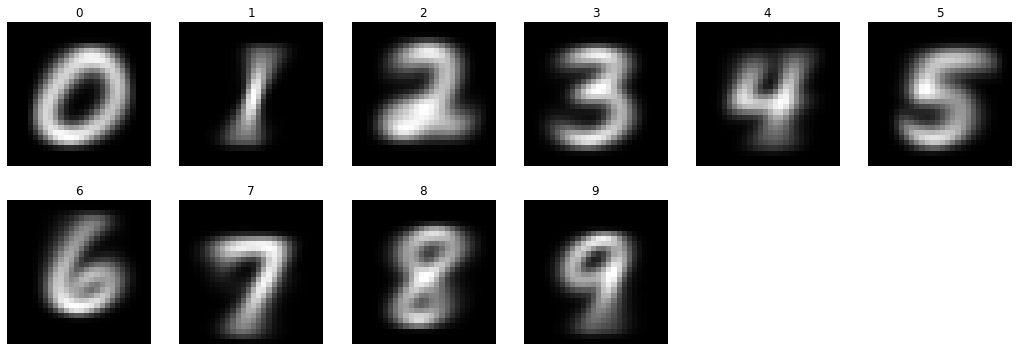

In [13]:
show_MNIST_images(pixel_data.reshape(10,28,28), [0,1,2,3,4,5,6,7,8,9])

#### Obserwacje:
* Można zauważyć, że krawędzie, dwa piksele z brzegu, nie wnoszą nowych informacji (występują tylko u uśrednionej siódemki).
* Nie znaleźliśmy innych zbędnych pikseli, ani pikseli, które pojawiałyby się często dla wszytkich cyfr.

### Wnioski:
* Aby  przyśpieszyć klasyfikację można pominąć dwupikselowe krawędzie.
* Z uwagi na małą liczbę pikseli możemy ich użyć jako artybutów.

## 2. Naiwny klasyfikator Bayesa

Naiwny klasyfikator Bayesa to prosty klasyfikator probalistyczny. Zakłada on niezależność atrybutów, co w przypadku pikseli prawdopodobnie jest błędnym założeniem. Jest on używany między innymi do wykrywania spamu.

Przygotowanie danych:

In [14]:
new_x_train = x_train.reshape(x_train.shape[0], 784)
new_x_test = x_test.reshape(x_test.shape[0], 784)
new_y_train = y_train.copy()
new_y_test = y_test.copy()

data = prepare_data(new_x_train, new_x_test, new_y_train, new_y_test)

Klasyfikator Bayesa:

In [15]:
bayes = GaussianNB()
train(data, bayes)

In [16]:
val_acc = bayes.score(data['desc_test'], data['class_test'])
print('Wartość poprawności {}'.format(val_acc))

Wartość poprawności 0.5558


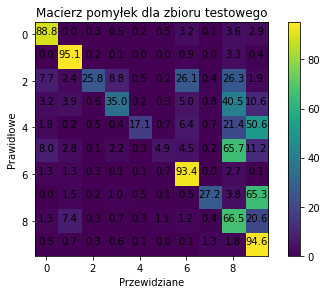

In [17]:
verify(data, bayes, in_percents=True)

Pomiar czasu klasyfikacji:

In [18]:
print_avg_time(data, bayes)

Średni czas poświęcony na klasyfikację jednego obrazu 0.050 ms.


#### Obserwacje
* Klasyfikator daje poprawność ok. 56%, co jest bardzo słabym wynikiem.
* Klasyfikator radzi sobie dobrze z cyframi 0, 1, 6 i 9.
* Klasyfikator bardzo często popełniał błąd klasyfikując daną cyfrę jako 8.
* Klasyfikator wydaje się nie być świadomym istnienia cyfry 5, ponieważ 65% razy klasyfikuje ją on jako liczbę 8.
* Również cyfra 4 wydaje się nie być brana pod uwagę, ponieważ 50% razy była klasyfikowana jako 9.
* Klasyfikator często mylił cyfrę 3 z 8 i cyfrę 7 z 9.
* Klasyfikator ma problem z rozpoznaniem cyfry 2, często klasyfikuje ją jako 6 albo 8.
* Czas 0,05 ms jest bardzo dobry.
* Mimo dużej prędkości niska dokładność sprawia, że nie można uznać tego klasyfikatora za przydatny.

## 3. Metoda najbliższego centroidu

Przygotowanie danych:

In [19]:
new_x_train = x_train.reshape(60000, 784)
new_x_test = x_test.reshape(10000, 784)
new_y_train = y_train.copy()
new_y_test = y_test.copy()

data = prepare_data(new_x_train, new_x_test, new_y_train, new_y_test)

Przygotowanie i trening klasyfikatora:

In [20]:
nc = NearestCentroid()
train(data, nc)

In [21]:
val_acc = nc.score(data['desc_test'], data['class_test'])
print('Wartość poprawności {}'.format(val_acc))

Wartość poprawności 0.8203


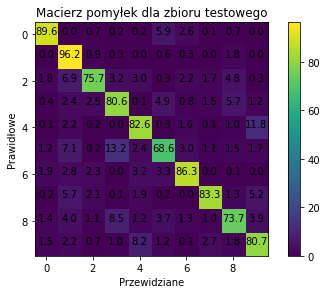

In [22]:
verify(data, nc, in_percents=True)

Pomiar czasu klasyfikacji:

In [23]:
print_avg_time(data, nc)

Średni czas poświęcony na klasyfikację jednego obrazu 0.007 ms.


#### Obserwacje
* Metoda najbliższego centroidu daje wynik 82% poprawności.
* Cyfra 5 klasyfikowana jest z zaledwie 68.6% dokładnością, najczęściej jest mylona z cyfrą 3.
* Najczęsciej mylone klasyfikacje to 4 jako 9, 8 jako 3 i 9 jako 4.
* Zaletą tego klasyfikatora jest duża prędkość.
* Lepsza od metody Bayesa, ale nadal niezadowalająca

## 4. Regresja logistyczna

Przygotowanie danych:

In [24]:
new_x_train = x_train[0:20000].reshape(20000, 784)
new_x_test = x_test[0:3000].reshape(3000, 784)
new_y_train = y_train[0:20000]
new_y_test = y_test[0:3000]

data = prepare_data(new_x_train, new_x_test, new_y_train, new_y_test)

Wyznaczenie najlepszej liczby iteracji:

In [25]:
def find_best_iter(data, iter_vals, plot_graph=False):
    filterwarnings('ignore', category=ConvergenceWarning)
    errors = []
    for iter in iter_vals:
        logreg = LogisticRegression(max_iter=iter)
        train(data, logreg)
        error = 1-logreg.score(data['desc_test'], data['class_test'])
        errors.append(error)
    if plot_graph:
        plt.figure(dpi=90)
        plt.plot(iter_vals, errors)
        plt.title('Wykres błędu')
        plt.xlabel('Liczba iteracji')
        plt.ylabel('Prawdopodobieństwo błędu')
    return iter_vals[np.argmin(errors)]

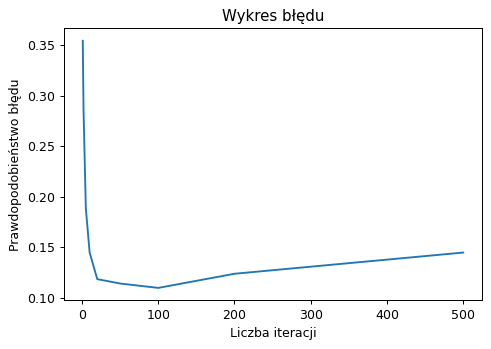

In [26]:
best_iter = find_best_iter(data, (1, 2, 5, 10, 20, 50, 100, 200, 500), plot_graph=True)

Nawet dla dużej liczby iteracji model regresji logistycznej nie zbiega do pełnego rozwiązania. Wymagana liczba iteracji do osiągnięcia zbieżności modelu przekracza nasze możliwości obliczeniowe. Co ciekawe, powyżej 100 iteracji poprawność modelu maleje, a nie wzrasta.

Regresja logiczna dla najlepszej znalezionej ilości iteracji:

In [27]:
logreg = LogisticRegression(max_iter = best_iter)
train(data, logreg)

In [28]:
acc = logreg.score(data['desc_test'], data['class_test'])
print('Wartość poprawności {}'.format(acc))

Wartość poprawności 0.8903333333333333


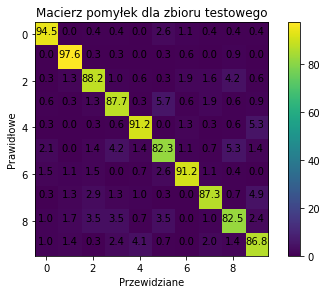

In [29]:
verify(data, logreg, in_percents=True)

In [30]:
print_avg_time(data, logreg)

Średni czas poświęcony na klasyfikację jednego obrazu 0.009 ms.


#### Obserwacje
* Regresja logistyczna daje prawie 90% poprawności.
* Model potrafi z dużą poprawnością sklasyfikować liczby 0, 1, 4 oraz 6.
* Model najgorzej radzi sobie z cyframi 5 oraz 8.
* Model najczęściej mylił ze sobą pary cyfr (3, 5), (2, 8), (4, 9), (5, 8) oraz (0, 5)
* W przeciwieństwie do poprzednich modeli pomyłki dotyczące par są tutaj obustronne. To znaczy, że zarówno 3 może być sklasyfikowane jako 5, ale też 5 jako 3 z prawie równym prawdopodobieństwem.
* Model klasyfikuje średnio jeden obraz w 7 mikrosekund, to doskonały wynik.
* Lepszy od poprzednich klasyfikatorów, ale nadal dość wysoka szansa błędnego rozpoznania cyfry.

## 5. Metoda k najbliższych sąsiadów

Przygotowanie danych (obcinanie marginesów i skalowanie w celu przyśpieszenia klasyfikatora):

In [31]:
new_x_train = reacale_images(x_train,margin=2,scale=0.5).reshape(x_train.shape[0], 144)
new_x_test = reacale_images(x_test,margin=2,scale=0.5).reshape(x_test.shape[0], 144)
new_y_train = y_train.copy()
new_y_test = y_test.copy()

data = prepare_data(new_x_train, new_x_test, new_y_train, new_y_test)

Wyznaczenie najlepszego k:

In [32]:
def find_best_k(data, kvals, plot_graph=False):
    errors = np.zeros(len(kvals))
    for i in range(0, len(kvals)):
        model = KNeighborsClassifier(n_neighbors=kvals[i])
        model.fit(data['desc_learn'], data['class_learn'])
        errors[i] = 1-model.score(data['desc_test'], data['class_test'])
    if plot_graph:
        plt.figure(dpi=90)
        plt.plot(kvals, errors)
        plt.title('Wykres błędu')
        plt.xlabel('Liczba sąsiadów')
        plt.ylabel('Prawdopodobienstwo błędu')
    return kvals[np.argmin(errors)]

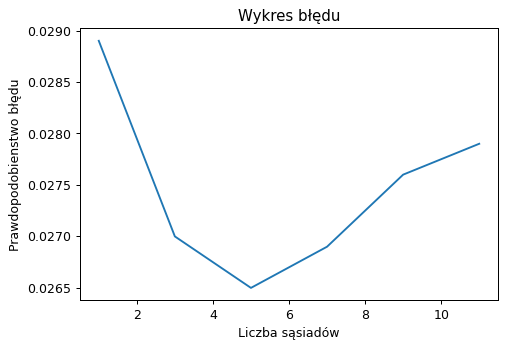

In [33]:
best_k = find_best_k(data, [1,3,5,7,9,11], plot_graph=True)

Precyzja klasyfikacji metodą najbliższych sąsiadów w dużej mierze zależy od ilości sąsiadów używanych do klasyfikacji. Dla prób na losowych podzbiorach najczęsciej najlepszym k było 3 (ok.40%), ale dla całego zbioru najlepsze jest 5.

Klasyfikator k-NN dla najlepszego znalezionego k:

In [34]:
knn = KNeighborsClassifier(best_k)
train(data,knn)

Pomiar czasu klasyfikacji:

In [35]:
val_acc = knn.score(data['desc_test'], data['class_test'])
print('Wartość poprawności {}'.format(val_acc))

Wartość poprawności 0.9735


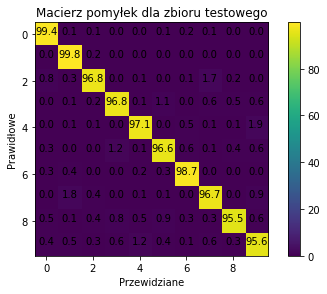

In [36]:
verify(data,knn,in_percents=True)

In [37]:
print_avg_time(data, knn)

Średni czas poświęcony na klasyfikację jednego obrazu 14.208 ms.


#### Obserwacje
* Wynik skuteczności 97% jest zaskakująco dobry i jest o wiele lepszy od wcześniejszych metod.
* Dobraliśmy najlepszą ilość sąsiadów, więc lepszego wyniku już nie uzyskamy.
* Najczęstszy błąd to klasyfikacja 7 jako 1 oraz 2 jako 7.
* Czas klasyfikacji obrazu jest bardzo długi, najdłuższy ze wszystkich metod.

## 6. SVM

Maszyna wektorów nośnych została zamieszczona w oryginalnym artykule twórców bazy.

Przygotowanie danych (obcinanie marginesów i skalowanie w celu przyśpieszenia klasyfikatora):

In [38]:
new_x_train = reacale_images(x_train,margin=2,scale=0.5).reshape(x_train.shape[0], 144)
new_x_test = reacale_images(x_test,margin=2,scale=0.5).reshape(x_test.shape[0], 144)
new_y_train = y_train.copy()
new_y_test = y_test.copy()

data = prepare_data(new_x_train, new_x_test, new_y_train, new_y_test)

Klasyfikator SVM:

In [39]:
svm = SVC()
train(data, svm)

In [40]:
val_acc = svm.score(data['desc_test'], data['class_test'])
print('Wartość poprawności {}'.format(val_acc))

Wartość poprawności 0.9812


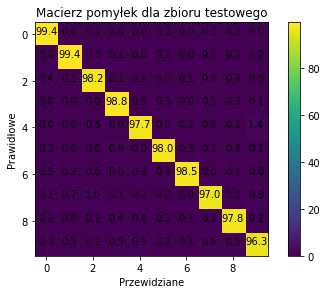

In [41]:
verify(data, svm, in_percents=True)

Pomiar czasu klasyfikacji:

In [42]:
print_avg_time(data, svm)

Średni czas poświęcony na klasyfikację jednego obrazu 1.863 ms.


#### Obserwacje
* Bardzo dobry wynik, poprawność klasyfikacji wynosi 98,12%.
* Bardzo dobry czas na klasyfikację jednego obrazu, czas ok. 2 ms.
* Zdecydowanie najlepszy do tej pory klasyfikator.

## 7. Głęboka sieć neuronowa

Wielowowarstwowa sieć neuronowa nie korzystająca z warstw konwolucyjnych. Przedstawiona sieć neuronowa posiada 5 warstw ukrytych, funkaja aktywacji to max(0, x).

Przygotowanie danych (normalizacja zwiększa poprawność klasyfikacji):

In [43]:
new_x_train = tf.keras.utils.normalize(x_train, axis=1)
new_x_test = tf.keras.utils.normalize(x_test, axis=1)

data = prepare_data(new_x_train, new_x_test, y_train, y_test)

Przygotowanie i trening sieci:

In [44]:
# dnn = tf.keras.models.Sequential()
# dnn.add(tf.keras.layers.Flatten())
# dnn.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
# dnn.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
# dnn.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
# dnn.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
# dnn.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
# dnn.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

# dnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# dnn.fit(data['desc_learn'], data['class_learn'], epochs=11)

Zapis modelu do pliku:

In [45]:
# dnn.save('dnn_mnist.model')

Wczytanie modelu z pliku:

In [46]:
dnn = tf.keras.models.load_model('dnn_mnist.model')

Sprawdzenie skuteczności klasyfikacji zbioru testowego:

In [47]:
loss, acc = dnn.evaluate(data['desc_test'], data['class_test'], verbose=0)
print('Wartość straty: {:.4f}\nWartość poprawności: {:.4f}'.format(loss, acc))

Wartość straty: 0.1346
Wartość poprawności: 0.9810


Tworzenie macierzy pomyłek:

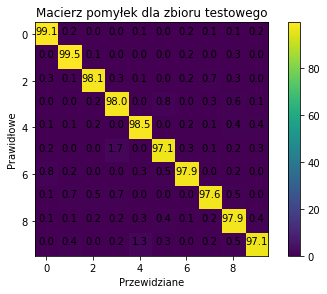

In [48]:
verify(data, dnn, in_percents=True)

Pomiar czasu klasyfikacji

In [49]:
print_avg_time(data, dnn)

Średni czas poświęcony na klasyfikację jednego obrazu 0.085 ms.


#### Obserwacje
* Bardzo dobra skuteczność. Jest minimalnie mniejsza od poprzedniego klasyfikatora.
* Dużo szybsza klasyfikacja od poprzedniego.
* Biorąc pod uwagę znacznie szybszą klasyfikację koszt drobnej utraty skuteczności jest nieistotny i można ten klasyfikator uznać za lepszy.

## 8. Konwolucyjna sieć neuronowa

Konwolucyjne sieci neuronowe to rodzaj sieci neuronowych, najczęściej używanych do klasyfikacji obrazów i wideo.
Użyte typy warstw to:
* konwolucyjne (dwuwymiarowe)
* łączące (dwuwymiarowe)
* regulacji opuszczeń(dropout)

Według jednago z rankingów to najlepszy znany sposób klasyfikacji. Sieci znajdujące się w nim są jednak znacznie większe od naszej.

Przygotowanie danych (normalizacja zwiększa poprawność klasyfikacji):

In [50]:
new_x_train = tf.keras.utils.normalize(x_train, axis=1)
new_x_test = tf.keras.utils.normalize(x_test, axis=1)

new_x_train = new_x_train.reshape(-1,28,28,1)
new_x_test = new_x_test.reshape(-1,28,28,1)
new_y_train = tf.keras.utils.to_categorical(y_train)
new_y_test = tf.keras.utils.to_categorical(y_test)

data = prepare_data(new_x_train, new_x_test, new_y_train, new_y_test)

Przygotowanie i trening sieci:

In [51]:
# cnn = tf.keras.models.Sequential()
# cnn.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation=tf.nn.relu, padding='same', input_shape=(28,28,1)))
# cnn.add(tf.keras.layers.Conv2D(32, kernel_size=5, activation=tf.nn.relu))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2))
# cnn.add(tf.keras.layers.Dropout(0.3))

# cnn.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu, padding='same'))
# cnn.add(tf.keras.layers.Conv2D(64, kernel_size=5, activation=tf.nn.relu))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2))
# cnn.add(tf.keras.layers.Dropout(0.3))

# cnn.add(tf.keras.layers.Flatten())
# cnn.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
# cnn.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

# cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# cnn.fit(data['desc_learn'], data['class_learn'], epochs=11)

Zapisanie modelu do pliku:

In [52]:
# cnn.save('cnn_mnist.model')

Wczytanie modelu z pliku:

In [53]:
cnn = tf.keras.models.load_model('cnn_mnist.model')

In [54]:
loss, acc = cnn.evaluate(data['desc_test'], data['class_test'], verbose=0)
print('Wartość straty: {:.4f}\nDokładność: {:.4f}'.format(loss, acc))

Wartość straty: 0.0288
Dokładność: 0.9938


Tworzenie macierzy pomyłek:

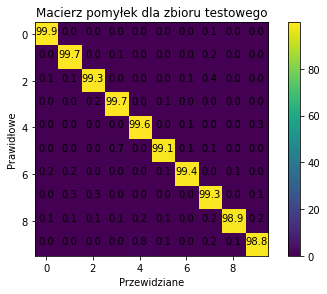

In [55]:
verify(data,cnn,in_percents=True)

Pomiar czasu klasyfikacji:

In [56]:
print_avg_time(data, cnn)

Średni czas poświęcony na klasyfikację jednego obrazu 0.643 ms.


#### Obserwacje
* Zaproponowana sieć neuronowa rozpoznaje cyfry z wysoką dokładnością 99,38%
* Czas na klasyfikację obrazu ok. 0,56 ms.
* Metoda jest bardzo skuteczna. Wprawdzie czas oczekiwania jest dłuższy od zwykłej sieci neuronowej, ale klasyfikacja jest prawie bezbłędna.

## Wnioski

* Cyfry przy których większość klasyfikatorów popełniała najmniej błędów to cyfry 0, 1, 6 oraz 9.
* Pomijając klasyfikator Bayesa, niezależnie od wybranego klasyfikatora najczęściej popełnianym błędem jest klasyfikacja 5 jako 3 oraz 9 jako 4.
* Klasyfikacja metodą Bayesa, najbliższego centroidu oraz logistyczną regresją jest zupełnie bezużyteczna w świetle istnienia innych metod.
* Metoda k najbliższych sąsiadów wypadła zadziwiająco dobrze, jednak jej wadą jest długi czas klasyfikacji.
* SVM uzyskała nieznacznie większą poprawność od głębokiej sieci neuronowej (o 0,02%), ale jest ok. 20 razy wolniejsza. Dlatego sieć neuronowa wydaje się lepszym rozwiązaniem.
* Jeżeli ważny jest dla nas czas, lepszym klasyfikatorem jest "podstawowy" (pierwszy) model sieci neuronowej, ponieważ działa ona 6 razy szybciej od CNN, chociaż jego poprawność jest o 1,3 pp. gorsza.
* Konwolucyjna sieć neuronowa wypadła najlepiej. Daje najwyższą dokładność w całkiem dobrym czasie.
* Rozwiązania oparte o sieci neuronowe są dużo lepsze od rozwiązań opartych o inne metody uczenia nadzorowanego.
* W porównaniu z najlepszymi rozwiązaniami w rankingu, zaprezentowane przez nas rozwiązania uzyskują mniejszą poprawność.

### Źródła:
* Wikipedia: https://en.wikipedia.org/wiki/MNIST_database